In [26]:
import os
import json
import pandas as pd
from tqdm import tqdm

In [17]:
def fewRel(path):
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
    data = {}
    for filename in os.listdir(path):
        if not filename.endswith('.json'):
            continue
        fullname = os.path.join(path, filename)
        
        with open(fullname) as f:
            fewRel_corpus = json.load(f)
            
            for relation, value in fewRel_corpus.items():
                for row in value:
                    sentences.append(row['tokens'])
                    relations.append(relation)
                    entities.append((row['h'][0].strip(),row['t'][0].strip()))
        data['sentence'] = sentences
        data['relation'] = relations
        data['entities'] = entities
    
    return data

In [20]:
df = pd.DataFrame(fewRel('data/'))

In [22]:
def random_rows_per_category(group):
    return group.sample(n=1, random_state=42) 

In [23]:
random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)

In [24]:
example = "'The FBI has jurisdiction over federal and local government in Texas.' is augumented to 'he CCB has jurisdiction over regional and local government in Brazil.'"

In [25]:
question = 'Write 5 augumented sentences of the following text' + example + ' text ='

In [32]:
all_augumented_data = []
for i in tqdm(range(10)):
    random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)
    for index, row in random_rows.iterrows():
        single_aug_data = {}
        sent = ' '.join(row['sentence'])
        augumented_text = rule_based_augmentation(sent)
        #print(process_data(augumented_text))
        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']
       # output = augumented_text +", " + row['relation'] + ", " +  row['entities'][0] +", " +  row['entities'][1]
        all_augumented_data.append(single_aug_data)

100%|██████████| 10/10 [00:00<00:00, 28.72it/s]


In [33]:
def save(file_path,data):
    with open(file_path, "w") as json_file:
        json.dump(data, json_file)

    print(f'Data saved to {file_path}')

In [34]:
file_path = "augumented_data/fewrel_50_pr_rulebased_data.json"
save(file_path,all_augumented_data)

Data saved to augumented_data/fewrel_50_pr_rulebased_data.json


In [36]:
def nytFb(path):
    dist = "train"
    
    temp_sent = ""
    
    temp_rel = ""
    data = {}
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
   
    for filename in os.listdir(path):
        if not filename.endswith('.json'): continue
        fullname = os.path.join(path, filename)
       
        if filename == "test.json":
            dist = 'test'
        elif filename == "train.json":
            dist = 'train'
        else:
            dist = 'valid'
        data2 = pd.read_json(r''+ fullname, lines=True)
        
        return data2
       
    return data

In [37]:
data_nyt = nytFb('data/nyt/')

In [39]:
def transform_row(row):
    sentence = row['sentText']
    relation = row['relationMentions'][0]['label'].split('/')[-1] 
    ent1 = row['entityMentions'][0]['text']
    ent2 = row['entityMentions'][1]['text']
    entities = (ent1, ent2)
    return sentence, relation, entities

# Apply the transformation function to each row and convert the result to a list of tuples
transformed_data = data_nyt.apply(transform_row, axis=1)

# Create a new DataFrame from the transformed data
nyt_df = pd.DataFrame(transformed_data.tolist(), columns=['sentence', 'relation', 'entities'])

56196

In [41]:
all_augumented_data = []
for i in tqdm(range(10)):
    random_rows = nyt_df.groupby('relation', group_keys=False).apply(random_rows_per_category)
    for index, row in random_rows.iterrows():
        single_aug_data = {}
        sent = row['sentence']
        augumented_text = rule_based_augmentation(sent)
        #print(process_data(augumented_text))
        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']
       # output = augumented_text +", " + row['relation'] + ", " +  row['entities'][0] +", " +  row['entities'][1]
        all_augumented_data.append(single_aug_data)

100%|██████████| 10/10 [00:00<00:00, 15.12it/s]


In [42]:
file_path = "augumented_data/nyt_50_pr_rulebased_data.json"
save(file_path,all_augumented_data)

Data saved to augumented_data/nyt_50_pr_rulebased_data.json


In [43]:
category_counts = nyt_df['relation'].value_counts()

print(category_counts)

relation
contains                    30240
nationality                  5219
place_lived                  5024
company                      3971
capital                      2430
neighborhood_of              2108
place_of_birth               1580
administrative_divisions     1518
country                      1517
place_of_death               1023
children                      381
founders                      377
place_founded                 318
major_shareholder_of           98
teams                          88
location                       86
major_shareholders             84
religion                       53
advisors                       34
geographic_distribution        26
ethnicity                       9
people                          9
profession                      2
industry                        1
Name: count, dtype: int64


In [44]:
threshold = 100

# Filter categories with counts less than the threshold
categories_below_threshold = category_counts[category_counts < threshold]

# Create two separate DataFrames based on the filter
df_below_threshold = nyt_df[nyt_df['relation'].isin(categories_below_threshold.index)]
df_above_threshold = nyt_df[~nyt_df['relation'].isin(categories_below_threshold.index)]


In [47]:
all_augmented_data = []

    # Iterate using tqdm for a progress bar
for i in tqdm(range(20), desc="Processing"):
    random_rows = df_below_threshold.groupby('relation', group_keys=False).apply(random_rows_per_category)

    for index, row in tqdm(random_rows.iterrows()):
        single_aug_data = {}
        sent = row['sentence']
        augumented_text = rule_based_augmentation(sent)

        single_aug_data['sentence'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']

        all_augmented_data.append(single_aug_data)

Processing:   0%|          | 0/20 [00:00<?, ?it/s]
11it [00:00, 552.19it/s]

11it [00:00, 580.13it/s]

11it [00:00, 817.89it/s]

11it [00:00, 897.58it/s]

11it [00:00, 1479.28it/s]
Processing:  25%|██▌       | 5/20 [00:00<00:00, 46.33it/s]
11it [00:00, 1466.59it/s]

11it [00:00, 1491.33it/s]

11it [00:00, 1484.90it/s]

11it [00:00, 1497.67it/s]

11it [00:00, 1499.18it/s]

11it [00:00, 1489.07it/s]

11it [00:00, 1498.94it/s]

11it [00:00, 1546.11it/s]

11it [00:00, 1481.13it/s]
Processing:  70%|███████   | 14/20 [00:00<00:00, 70.22it/s]
11it [00:00, 1492.63it/s]

11it [00:00, 1493.55it/s]

11it [00:00, 1499.72it/s]

11it [00:00, 1493.21it/s]

11it [00:00, 1485.19it/s]

11it [00:00, 1498.31it/s]
Processing: 100%|██████████| 20/20 [00:00<00:00, 71.81it/s]


In [48]:
file_path = "augumented_data/nyt_less100_100Plus_rulebased_data.json"
save(file_path,all_augumented_data)

Data saved to augumented_data/nyt_less100_100Plus_rulebased_data.json


In [2]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Function to get synonyms of a word
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Function to perform rule-based data augmentation
def rule_based_augmentation(sentence):
    words = sentence.split()  # Tokenize the sentence
    augmented_sentences = []

    for i, word in enumerate(words):
        synonyms = get_synonyms(word)
        if synonyms:
            for synonym in synonyms:
                new_sentence = " ".join(words[:i] + [synonym] + words[i+1:])
                augmented_sentences.append(new_sentence)

    return augmented_sentences[:5]

# Example sentence for data augmentation
input_sentence = "The workers often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday."

# Perform rule-based data augmentation
augmented_sentences = rule_based_augmentation(input_sentence)

# Display the augmented sentences
print("Original Sentence:")
print(input_sentence)

print("\nAugmented Sentences:")
for sentence in augmented_sentences:
    print(sentence)


Original Sentence:
The workers often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday.

Augmented Sentences:
The worker often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday.
The prole often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday.
The doer often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday.
The proletarian often arrive in convoys , like the 47 repair vehicles from FirstEnergy , a utility holding company in Akron , Ohio , that pulled into the Coliseum parking lot Saturday.
The actor often arrive in convoys , like the 47 repair v

[nltk_data] Downloading package wordnet to
[nltk_data]     /upb/users/m/manzoor/profiles/unix/cs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
pip install textstat


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import textstat

text = "The ACIC has jurisdiction over federal and local government in Australia. "

# Calculate the Flesch-Kincaid score
flesch_score = textstat.flesch_kincaid_grade(text)

print(f"Flesch-Kincaid Readability Score: {flesch_score}")


Flesch-Kincaid Readability Score: 9.9


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /upb/users/m/manzoor/profiles/unix/cs/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [51]:
sentence1 = "This is the first sentence for comparison."
sentence2 = "This is the second sentence for comparison."

sentences = [sentence1, sentence2]

In [52]:
vectorizer = CountVectorizer().fit_transform(sentences)
vectors = vectorizer.toarray()

In [53]:
cosine_sim = cosine_similarity(vectors)

In [54]:
similarity_score = cosine_sim[0][1]
print(f"Cosine Similarity Score: {similarity_score}")

Cosine Similarity Score: 0.8571428571428569


### Below is the code for last table

In [20]:
def calculate_complexity(sentence):
    try:
        return textstat.flesch_kincaid_grade(sentence)
    except:
        return None  # Handle cases where the textstat library may throw an exception

# Apply the function to the 'sentences' column


In [1]:
import pandas as pd

#### NYT data load

In [217]:
data = pd.read_csv('fewRel_entities.csv')

In [193]:
data_nyt = pd.read_csv('data/nyt.csv')

In [152]:
data_nyt_falcon = pd.read_csv('data/nyt_aug_falcon_50.csv')

In [153]:
data_nyt_llama = pd.read_csv('data/nyt_aug_llama_50.csv')

In [154]:
data_nyt_rule = pd.read_csv('data/nyt_aug_rule_50.csv')

In [156]:
data_nyt_rule['complexity'] = data_nyt_rule['sentence'].apply(calculate_complexity)
data_nyt_falcon['complexity'] = data_nyt_falcon['sentence'].apply(calculate_complexity)
data_nyt_llama['complexity'] = data_nyt_llama['sentence'].apply(calculate_complexity)

In [157]:
details(data_nyt_rule)
details(data_nyt_falcon)
details(data_nyt_llama)


Average Complexity: 14.284166666666666, min complexity: 4.3 and max complexity: 24.4, standered deviation= 5.178031412932588
Average Complexity: 11.1375, min complexity: 5.6 and max complexity: 21.3, standered deviation= 3.007997749120766
Average Complexity: 12.904596622889304, min complexity: -15.7 and max complexity: 32.2, standered deviation= 5.172718927676214


In [177]:
print(numEntities(data_nyt_rule))
print(numEntities(data_nyt_falcon))
print(numEntities(data_nyt_llama))


5.291666666666667
2.158333333333333
3.6397748592870545


In [184]:
claculateTokens(data_nyt_rule)
claculateTokens(data_nyt_falcon)
claculateTokens(data_nyt_llama)


Average number of tokens across all sentences: 42.791666666666664

Average number of tokens across all sentences: 17.116666666666667

Average number of tokens across all sentences: 36.15384615384615


In [206]:

avgCosineSim(data_nyt_rule)
avgCosineSim(data_nyt_falcon)
avgCosineSim(data_nyt_llama)


Average cosine similarity between sentences: 0.2456338983887971

Average cosine similarity between sentences: 0.39441716727522363

Average cosine similarity between sentences: 0.16971563518938332


#### Fewrel dataload

In [173]:
data_fewrel_falcon = pd.read_csv('aug_falcon_entities.csv')
data_fewrel_llama = pd.read_csv('aug_llama_entities_cleaned.csv')
data_fewrel_rule = pd.read_csv('aug_rule_entities.csv')

In [174]:
data_fewrel_falcon['complexity'] = data_fewrel_falcon['sentence'].apply(calculate_complexity)
data_fewrel_llama['complexity'] = data_fewrel_llama['sentence'].apply(calculate_complexity)
data_fewrel_rule['complexity'] = data_fewrel_rule['sentence'].apply(calculate_complexity)

In [175]:
details(data_fewrel_falcon)
details(data_fewrel_llama)
details(data_fewrel_rule)


Average Complexity: 11.62875, min complexity: 3.2 and max complexity: 20.6, standered deviation= 3.1047944149109363
Average Complexity: 13.358605821056415, min complexity: 1.3 and max complexity: 50.9, standered deviation= 4.298414408086651
Average Complexity: 10.678125, min complexity: 2.1 and max complexity: 20.9, standered deviation= 3.29674732183595


In [176]:
print(f'falcon = {numEntities(data_fewrel_falcon)}')
print(f'llama = {numEntities(data_fewrel_llama)}')
print(f'rule = {numEntities(data_fewrel_rule)}')

rule = 2.35
llama = 3.943586058210564
falcon = 4.109375


In [188]:
claculateTokens(data_fewrel_rule)
claculateTokens(data_fewrel_falcon)
claculateTokens(data_fewrel_llama)


Average number of tokens across all sentences: 24.875

Average number of tokens across all sentences: 18.765625

Average number of tokens across all sentences: 32.842256557671575


In [207]:
avgCosineSim(data_fewrel_rule)
avgCosineSim(data_fewrel_falcon)
avgCosineSim(data_fewrel_llama)


Average cosine similarity between sentences: 0.1578490177926236

Average cosine similarity between sentences: 0.3709857184793308

Average cosine similarity between sentences: 0.1846967784163656


In [195]:
data.head()

,sentence,relation,entities
0,Merpati flight 106 departed Jakarta ( CGK ) on...,P931,"('tjq', 'tanjung pandan')"
1,The name was at one point changed to Nottingha...,P931,"('east midlands airport', 'nottingham')"
2,It is a four - level stack interchange near Fo...,P931,('fort lauderdale-hollywood international airp...
3,It is the main alternate of Jinnah Internation...,P931,"('jinnah international airport', 'karachi')"
4,Nearby airports include Akwa Ibom Airport at O...,P931,"('margaret ekpo international airport', 'calab..."


In [198]:
claculateTokens(data)



Average number of tokens across all sentences: 25.00049107142857


In [199]:
claculateTokens(data_nyt)


Average number of tokens across all sentences: 37.81715780482597


In [28]:
data_nyt['complexity'] = data_nyt['sentence'].apply(calculate_complexity)

In [29]:
data['complexity'] = data['sentence'].apply(calculate_complexity)


In [13]:
def details(data):    
    average_complexity = data['complexity'].mean()
    min_complexity = data['complexity'].min()
    max_complexity = data['complexity'].max()
    std_deviation_complexity = data['complexity'].std()

    # Display the average complexity score
    print(f'Average Complexity: {average_complexity}, min complexity: {min_complexity} and max complexity: {max_complexity}, standered deviation= {std_deviation_complexity}')

In [30]:
details(data) ### Fewrel

Average Complexity: 10.345794642857141, min complexity: -2.3 and max complexity: 25.6, standered deviation= 3.2103797695110985


In [31]:
details(data_nyt) ### Nyt-fb

Average Complexity: 12.894590362303365, min complexity: -2.7 and max complexity: 40.0, standered deviation= 5.353198862675786


In [213]:
#avgCosineSim(data)
avgCosineSim(data_nyt)


Average cosine similarity between sentences: 0.1916743467349068


In [220]:
avgCosineSim(data)


Average cosine similarity between sentences: 0.1583082503517445


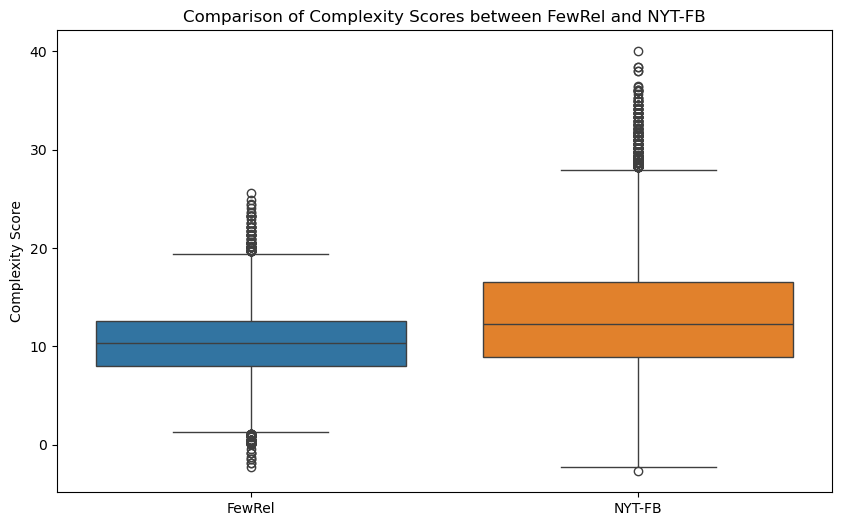

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have two DataFrames: df1 and df2 with 'complexity' column

# Combine the datasets into a single DataFrame
combined_df = pd.concat([data['complexity'], data_nyt['complexity']], axis=1)
combined_df.columns = ['FewRel', 'NYT-FB']

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df)
plt.title('Comparison of Complexity Scores between FewRel and NYT-FB')
plt.ylabel('Complexity Score')
plt.show()


In [32]:
nyt_aug_df = pd.concat([data_nyt['complexity'],data_nyt_falcon['complexity'], data_nyt_llama['complexity'], data_nyt_rule['complexity']], axis=1)
nyt_aug_df.columns = ['NYT-FB','Falcon', 'Llama', 'Rule']

# Create a boxplot


In [101]:
fewrel_aug_df= pd.concat([data['complexity'],data_fewrel_falcon['complexity'], data_fewrel_llama['complexity'], data_fewrel_rule['complexity']], axis=1)
fewrel_aug_df.columns = ['FewRel','Falcon', 'Llama', 'Rule']

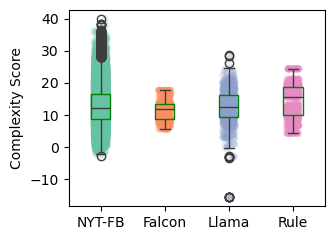

In [232]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame nyt_aug_df with 'complexity' column

plt.figure(figsize=(7/2, 5/2))

ax = sns.boxplot(data=nyt_aug_df, showfliers=True, boxprops=dict(facecolor='None', edgecolor='green'), width=0.3, zorder=2)
#ax = sns.boxplot(data=data_nyt_falcon['complexity'], showfliers=True, boxprops=dict(facecolor='None', edgecolor='green'), width=0.3, zorder=2,positions=[1])
#ax = sns.boxplot(data=data_nyt_llama['complexity'], showfliers=True, boxprops=dict(facecolor='None', edgecolor='green'), width=0.3, zorder=2,positions=[1.5])
#ax = sns.boxplot(data=data_nyt_rule['complexity'], showfliers=True, boxprops=dict(facecolor='None', edgecolor='green'), width=0.3, zorder=2,positions=[2.0])
ax.set_aspect(0.05)


sns.stripplot(data=nyt_aug_df, jitter=True, palette="Set2", alpha=0.2, ax = ax,zorder=0)
#sns.stripplot(data=data_nyt_falcon['complexity'], jitter=True, palette="Set3", alpha=0.2, ax = ax,zorder=0)
#sns.stripplot(data=data_nyt_llama['complexity'], jitter=True, palette="Set3", alpha=0.2, ax = ax,zorder=0)
#sns.stripplot(data=data_nyt_rule['complexity'], jitter=True, palette="Set3", alpha=0.2, ax = ax,zorder=0)
#plt.title('Comparison of Complexity Scores between Falcon, Llama, and Rule for NYT-FB dataset')
plt.ylabel('Complexity Score')

plt.tight_layout()  # Ensure the labels and title fit within the figure
plt.savefig('images2/nyt_complexity.png', dpi=300)  # Save as PNG with 300 DPI
plt.show()

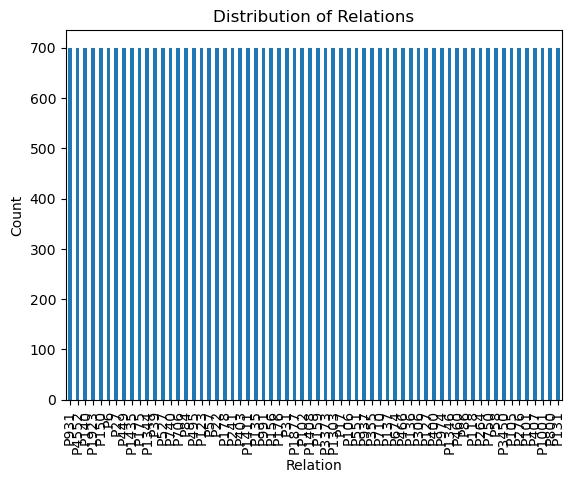

In [108]:
relation_counts = data['relation'].value_counts()

# Plot the bar graph
relation_counts.plot(kind='bar')

plt.title('Distribution of Relations')
plt.xlabel('Relation')
plt.ylabel('Count')
plt.show()

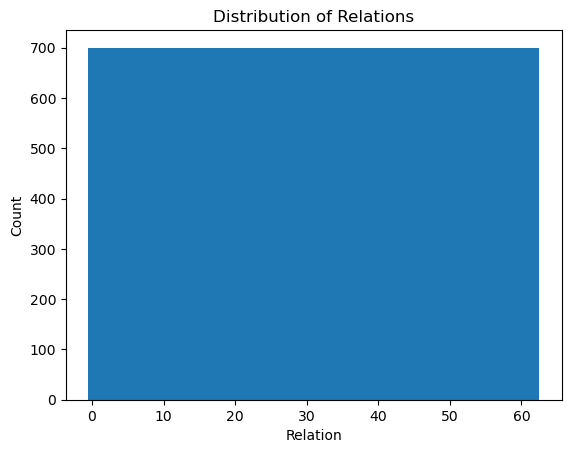

In [113]:
data['relation_id'] = pd.factorize(data['relation'])[0]

# Plot the histogram
plt.hist(data['relation_id'], bins=len(data['relation'].unique()), align='left')

plt.title('Distribution of Relations')
plt.xlabel('Relation')
plt.ylabel('Count')
plt.show()

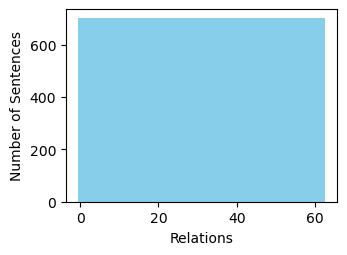

In [230]:
data['relation_id'] = pd.factorize(data['relation'])[0]
colors = ['orange']
plt.figure(figsize=(7/2, 5/2))
# Plot the histogram
plt.hist(data['relation_id'], bins=len(data['relation'].unique()), align='left', color=colors)

#plt.title('Distribution of Relations')
plt.xlabel('Relations')
plt.ylabel('Number of Sentences')

# Save the figure as a PDF
plt.savefig('images2/fewrel_relation_distribution.pdf', bbox_inches='tight',dpi=300)
plt.show()

In [172]:
import ast
def numEntities(data):
    data['entities'] = data['entities'].apply(ast.literal_eval)
    data['tuple_length'] = data['entities'].apply(len)

# Calculate the total number of values across all tuples
    data_sum = data['tuple_length'].sum()
    return data_sum/len(data)

In [196]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Sample DataFrame with a 'sentences' column
def claculateTokens(df):

    # Tokenize the sentences and calculate the number of tokens for each sentence
    df['num_tokens'] = df['sentence'].apply(lambda x: len(word_tokenize(x)))

    # Calculate the average number of tokens across all sentences
    average_tokens = df['num_tokens'].mean()
    print("\nAverage number of tokens across all sentences:", average_tokens)


In [200]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


In [219]:
# Sample DataFrame with a 'sentences' column

def avgCosineSim(df):
    # Create a CountVectorizer to convert sentences to vectors
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['sentence'])

    # Calculate cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(X, X)

    # Convert the similarity matrix to DataFrame for better visualization
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=df.index, index=df.index)

    # Calculate the average cosine similarity excluding self-similarity
    average_cosine_similarity = cosine_sim_df.mask(cosine_sim_df == 1.0).mean().mean()
    print("\nAverage cosine similarity between sentences:", average_cosine_similarity)